# Part 4: Sentiment of the artists and communities

The questions below are based on Lecture 8

* Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
* Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?

In [19]:
# Load graph with genres without including isolated nodes
import json
import networkx as nx
import requests
import gzip
import io
import os

local_network = "data/rock_band_graph_isolated_genres.json.gz"
read_graph_kwargs = {"comments": "#", "delimiter": "|", "create_using": nx.DiGraph()}

if os.path.exists(local_network):
    with gzip.open(local_network, "rt", encoding="utf-8") as fh:
        G_bands = nx.readwrite.node_link_graph(json.load(fh), edges="links")
    print(
        f"Loaded graph with {G_bands.number_of_nodes()} nodes and {G_bands.number_of_edges()} edges containing bands and genres.",
        f"Graph component count: {len(list(nx.weakly_connected_components(G_bands)))}",
        sep="\n",
    )
else:
    print("Graph file not found.")

Loaded graph with 484 nodes and 7323 edges containing bands and genres.
Graph component count: 1


In [20]:
import pandas as pd
import numpy as np
import networkx as nx
import os
# get sentimantal scores from dataset
df = pd.read_csv("data/Data_Set_S1.csv")

df_sentimental_words = df[['word', 'happiness_average']]

def calculate_sentiment(text, df, word_col='word'):

    # Split text into lowercase words
    words = [w.lower() for w in text.split()]
    
    # Filter dataset for matching words
    matches = df[df[word_col].isin(words)]
    
    if matches.empty:
        return np.nan, []
    
    # Use happiness_average as sentiment score
    sentiment_score = matches['happiness_average'].mean()
    
    return sentiment_score, matches[word_col].tolist()



total_bands_processed = 0
bands_with_files = 0
bands_without_files = 0
results = []  # collect (node, sentiment) tuples
# calculate using the filtered graph with genres
for i, (node, genres) in enumerate(G_bands.nodes(data=True)):
    # skip nodes without genre metadata
    if not genres or len(genres) == 0:
        continue

    total_bands_processed += 1
    first_genre = genres.get('genres', [None])[0]

    # sanitize filename (replace spaces and forward slashes)
    safe_name = node.replace(' ', '_').replace('/', '_')
    filename = f"data/wiki_pages/{safe_name}.txt"

    if os.path.exists(filename):
        try:
            with open(filename, 'r', encoding='utf-8') as f:
                text = f.read()

            # calculate sentiment for the page text
            sentiment_score, matched_words = calculate_sentiment(text, df_sentimental_words)
            
            # store results on the graph node (so you can later examine or export them)
            G_bands.nodes[node]['sentiment'] = sentiment_score
            G_bands.nodes[node]['sentiment_matches'] = matched_words
            
            results.append((node, first_genre, sentiment_score))
            bands_with_files += 1
            # occasional progress print
            if bands_with_files % 200 == 0:
                print(f"Processed {bands_with_files} pages (latest: {node})")

        except Exception as e:
            print(f"⚠️  Error reading {filename}: {e}")
            G_bands.nodes[node]['sentiment_error'] = str(e)
            bands_without_files += 1
    else:
        # file doesn't exist for this band
        bands_without_files += 1

# summary of work
print(f"Bands without wiki page files or errors: {bands_without_files}")
print(f"Bands with wiki page files processed: {bands_with_files}")


Processed 200 pages (latest: Flyleaf (band))
Processed 400 pages (latest: Silverchair)
Bands without wiki page files or errors: 0
Bands with wiki page files processed: 484


Descriptive Statistics for Sentiment Scores:


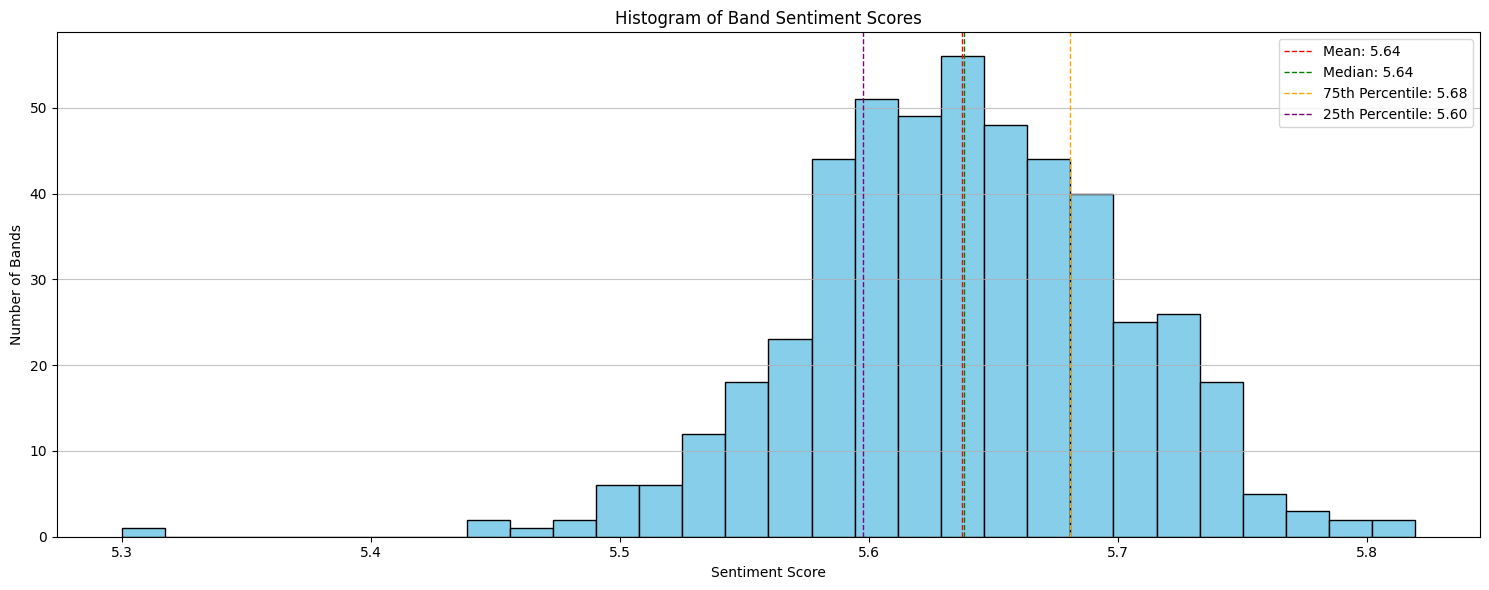

count    484.000000
mean       5.637203
std        0.063619
min        5.300000
25%        5.597485
50%        5.638078
75%        5.680834
max        5.819261
dtype: float64


In [21]:
# histogram of sentiment scores using graph with all nodes
import matplotlib.pyplot as plt
sentiment_scores = [sentiment for _, _, sentiment in results if sentiment is not None]
# describe sentiment scores
print("Descriptive Statistics for Sentiment Scores:")
description = pd.Series(sentiment_scores).describe()

# add description using subplots
fig, ax = plt.subplots(figsize=(15, 6))
ax.hist(sentiment_scores, bins=30, color='skyblue', edgecolor='black')
ax.set_title('Histogram of Band Sentiment Scores')
ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Number of Bands')
ax.grid(axis='y', alpha=0.75)
# axvlines for mean and median, 75% and 25%

mean_score = description['mean']
median_score = description['50%']
percentile_75 = description['75%']
percentile_25 = description['25%']

ax.axvline(mean_score, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_score:.2f}')
ax.axvline(median_score, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_score:.2f}')
ax.axvline(percentile_75, color='orange', linestyle='dashed', linewidth=1, label=f'75th Percentile: {percentile_75:.2f}')
ax.axvline(percentile_25, color='purple', linestyle='dashed', linewidth=1, label=f'25th Percentile: {percentile_25:.2f}')

ax.legend()

plt.tight_layout()
plt.show()
print(description)
# detect communities using Louvain method

In [22]:
# USING ONLY NODES WITH GENRES AS IN PART 2 TO RESULT IN COMPARABLE COMMUNITIES
G_undirected = G_bands.to_undirected()

nodes_with_genres_list = [
    node
    for node in G_undirected.nodes()
    if "genres" in G_undirected.nodes[node] and G_undirected.nodes[node]["genres"]
]

G_genres = G_undirected.subgraph(nodes_with_genres_list).copy()

In [23]:
import networkx.algorithms.community as nx_comm

print("STRUCTURAL COMMUNITY DETECTION - LOUVAIN ALGORITHM")
print("COMMUNITIES ARE CALCULATED USING THE FILTERED GRAPH WITH GENRES AS IN PART 2")
print("=" * 50)

# Apply Louvain algorithm to find communities
louvain_communities = nx_comm.louvain_communities(G_genres,  resolution=1.5,seed=42)


STRUCTURAL COMMUNITY DETECTION - LOUVAIN ALGORITHM
COMMUNITIES ARE CALCULATED USING THE FILTERED GRAPH WITH GENRES AS IN PART 2


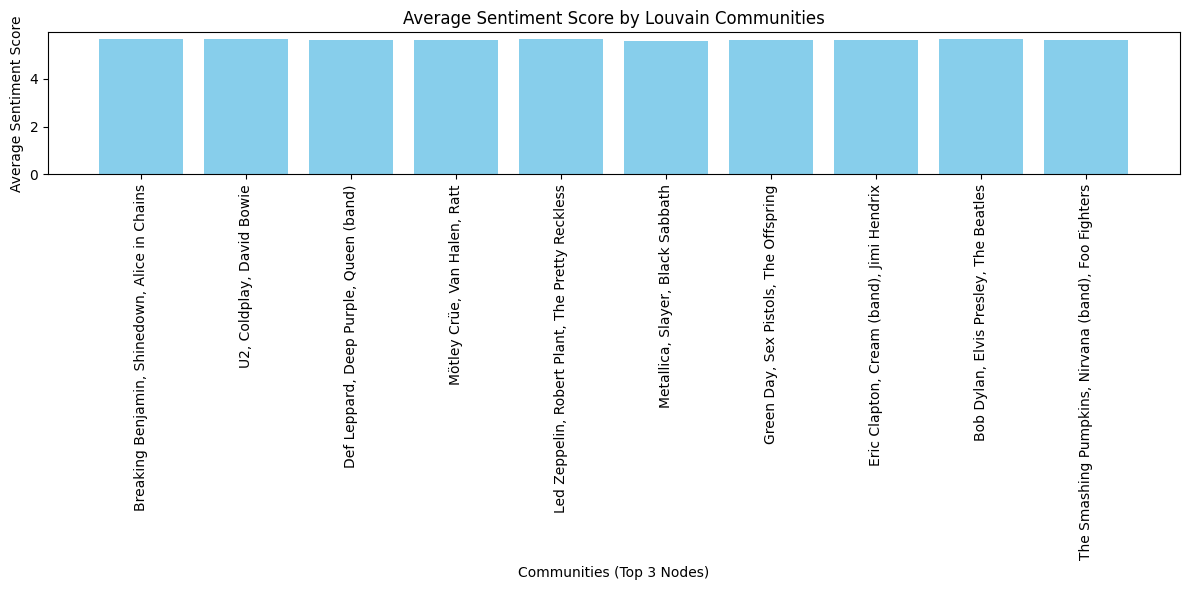

In [24]:
# For this exercise, we use the structural communities (just the 10 largest ones)
community_sentiments = []
for i, comm in enumerate(louvain_communities):
    comm_sentiments = []
    for node in comm:
        sentiment = G_genres.nodes[node].get('sentiment')
        if sentiment is not None:
            comm_sentiments.append(sentiment)
    if comm_sentiments:
        avg_sentiment = sum(comm_sentiments) / len(comm_sentiments)
    else:
        avg_sentiment = None
    community_sentiments.append((i, len(comm), avg_sentiment))
# name communities by the 3 most connected nodes
comm_names = []
for i, comm in enumerate(louvain_communities):
    subgraph = G_genres.subgraph(comm)
    degrees = subgraph.degree()
    top_nodes = sorted(degrees, key=lambda x: x[1], reverse=True)[:3]
    name = ", ".join([n[0] for n in top_nodes])
    comm_names.append(name)
#plot community sentiments

import matplotlib.pyplot as plt
comm_ids = [c[0] for c in community_sentiments]
comm_sizes = [c[1] for c in community_sentiments]
comm_avg_sentiments = [c[2] for c in community_sentiments]

plt.figure(figsize=(12, 6))
plt.bar(comm_ids, comm_avg_sentiments, color='skyblue')
plt.xticks(comm_ids, comm_names, rotation=90)
plt.xlabel("Communities (Top 3 Nodes)")
plt.ylabel("Average Sentiment Score")
plt.title("Average Sentiment Score by Louvain Communities")
plt.tight_layout()
plt.show()

In [25]:
# happiest and saddest communities
happiest_com = max(community_sentiments, key=lambda x: x[2])
saddest_com = min(community_sentiments, key=lambda x: x[2])
print(f"Happiest Community: ID {happiest_com[0]}, Size {happiest_com[1]}, Avg Sentiment {happiest_com[2]:.4f}, Name: {comm_names[happiest_com[0]]}")
print(f"Saddest Community: ID {saddest_com[0]}, Size {saddest_com[1]}, Avg Sentiment {saddest_com[2]:.4f}, Name: {comm_names[saddest_com[0]]}")
txt_name_saddest = comm_names[saddest_com[0]]
txt_name_happiest = comm_names[happiest_com[0]]

print(txt_name_saddest.join(', '))
print(txt_name_happiest.join(', '))
score, matched = calculate_sentiment(txt_name_saddest, df)
print('saddest: ', score, matched)
score, matched = calculate_sentiment(txt_name_happiest, df)
print('happiest: ', score, matched)


Happiest Community: ID 1, Size 64, Avg Sentiment 5.6657, Name: U2, Coldplay, David Bowie
Saddest Community: ID 5, Size 40, Avg Sentiment 5.5771, Name: Metallica, Slayer, Black Sabbath
,Metallica, Slayer, Black Sabbath 
,U2, Coldplay, David Bowie 
saddest:  4.88 ['black']
happiest:  5.5 ['david']


## Findings

### 1. Neutral Tone of Wikipedia
Wikipedia pages are intentionally written to maintain a neutral and factual tone. 
As a result, sentiment scores across pages tend to cluster around neutrality, with little emotional variation. We see that the median and the mean are exactly the same value and the distribution of sentiment scores is uniform.

### 2. High Vocabulary Overlap
The majority of words are shared among pages, as confirmed by word cloud analysis. 
This reflects the standardized structure and style of Wikipedia articles 
(e.g., sections like *Early Life*, *Discography*, *Reception*).

### 3. Consistent Node Sentiments
When evaluating each node (individual page) separately, sentiment scores remain very similar. 
This further supports the hypothesis that Wikipedia’s editorial guidelines minimize emotional language.

### 4. Community-Level Analysis Adds Little Value
Aggregating nodes into communities does not provide additional insight. 
Since nodes within a community have nearly identical sentiment distributions, 
the community sentiment averages out, revealing no meaningful differentiation between them.

### 5. Relation with TF-IDF

Term frequency alone does not capture what is distinctive about a text—it mainly reflects words that are frequent across all texts. In contrast, TF-IDF helps identify words that are **common within a specific genre** but **rare across others**. The inverse document frequency (IDF) component weights each word according to its rarity in a larger corpus, highlighting what makes each text distinctive and providing a better characterization of subsets of texts.

When we applied TF-IDF to texts grouped by genre, we found that the top-ranked words were mostly artists’ names. These appeared frequently on the artists’ own pages due to the high number of citations and references. Similarly, the sentiment analysis of the structural communities led to a comparable conclusion: there was no clear relationship between the sentiment of the words used to describe the artists on Wikipedia and the way they form structural communities. Likewise, there was no evident relationship between the artists’ genres and the language used to describe them within those genres.

   Community_ID  Size  Community_Sentiment  Name_Sentiment  \
5             5    40             5.577100        4.880000   
3             3    28             5.612601        5.200000   
2             2    49             5.625047        5.646667   
6             6    36             5.627886        6.400000   
7             7    36             5.633250        5.940000   
9             9    47             5.641477        4.980000   
0             0    51             5.650514        4.882500   
8             8   108             5.653910        5.735000   
4             4     8             5.659777        5.364000   
1             1    64             5.665729        5.500000   

                        Matched_Words  
5                               black  
3                                 van  
2                    queen, deep, def  
6                     sex, green, the  
7                         cream, eric  
9                                 the  
0         alice, in, chains, breaking

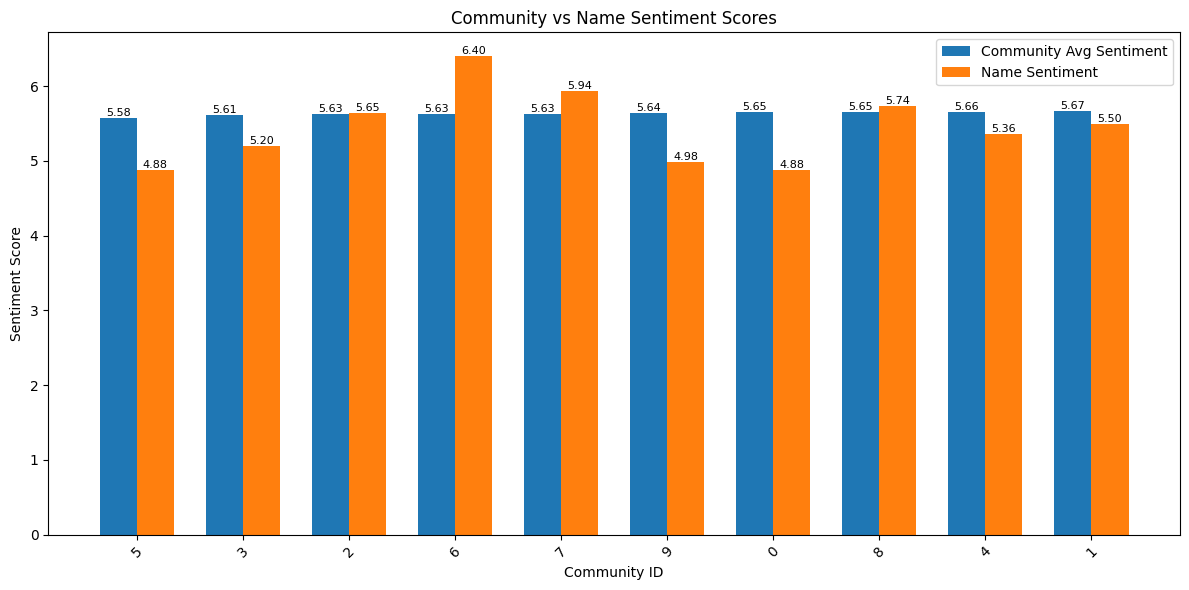

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Compute sentiment for all communities
results = []
for com_id, size, avg_sent in community_sentiments:
    txt_name = comm_names[com_id]
    score, matched = calculate_sentiment(txt_name, df)
    results.append({
        'Community_ID': com_id,
        'Size': size,
        'Community_Sentiment': avg_sent,
        'Name_Sentiment': score,
        'Name': txt_name,
        'Matched_Words': ', '.join(matched)
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Sort by community sentiment (or name sentiment, depending on preference)
results_df = results_df.sort_values(by='Community_Sentiment', ascending=True)

# Print table summary
print(results_df[['Community_ID', 'Size', 'Community_Sentiment', 'Name_Sentiment', 'Matched_Words']])

# --- Plot ---
x = np.arange(len(results_df))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width/2, results_df['Community_Sentiment'], width, label='Community Avg Sentiment')
bars2 = ax.bar(x + width/2, results_df['Name_Sentiment'], width, label='Name Sentiment')

ax.set_title('Community vs Name Sentiment Scores')
ax.set_xlabel('Community ID')
ax.set_ylabel('Sentiment Score')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Community_ID'].astype(str), rotation=45)
ax.legend()

# Add sentiment value labels above bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


### 6. Other findings

Building on the TF-IDF analysis, where the most relevant words associated with each genre were often the names of artists, we explored whether the most frequently cited artist names within each community were related to the community’s happiness level. To do so, we compared the average happiness of each community with the sentiment of its name, defined by the three most connected (and therefore most cited) artists within it. Although no clear correlation was found given that all communities sentiment scores are very close to the mean, the happiest community included name-matching words such as “david”, which showed higher sentiment scores than those in the saddest community, where the matching words included “black.”
